In [2]:
!pip install qiskit qiskit-aer matplotlib pylatexenc qiskit_ibm_runtime


Grover's Algorithm with 3 qubits
Total states: 8
Grover iterations: 2
Searching for state: |111⟩

Circuit:
     ┌───┐ Init                 Oracle 1 ┌───┐┌───┐          ┌───┐┌───┐     »
q_0: ┤ H ├──░──────────■───────────░─────┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────»
     ├───┤  ░          │           ░     ├───┤├───┤       │  ├───┤├───┤     »
q_1: ┤ H ├──░──────────■───────────░─────┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────»
     ├───┤  ░   ┌───┐┌─┴─┐┌───┐    ░     ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐»
q_2: ┤ H ├──░───┤ H ├┤ X ├┤ H ├────░─────┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├»
     └───┘  ░   └───┘└───┘└───┘    ░     └───┘└───┘└───┘└───┘└───┘└───┘└───┘»
c: 3/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«      Diff 1                 Oracle 2 ┌───┐┌───┐          ┌───┐┌───┐     »
«q_0: ───░───────────■───────────░─────┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────»
«        ░           │           ░    

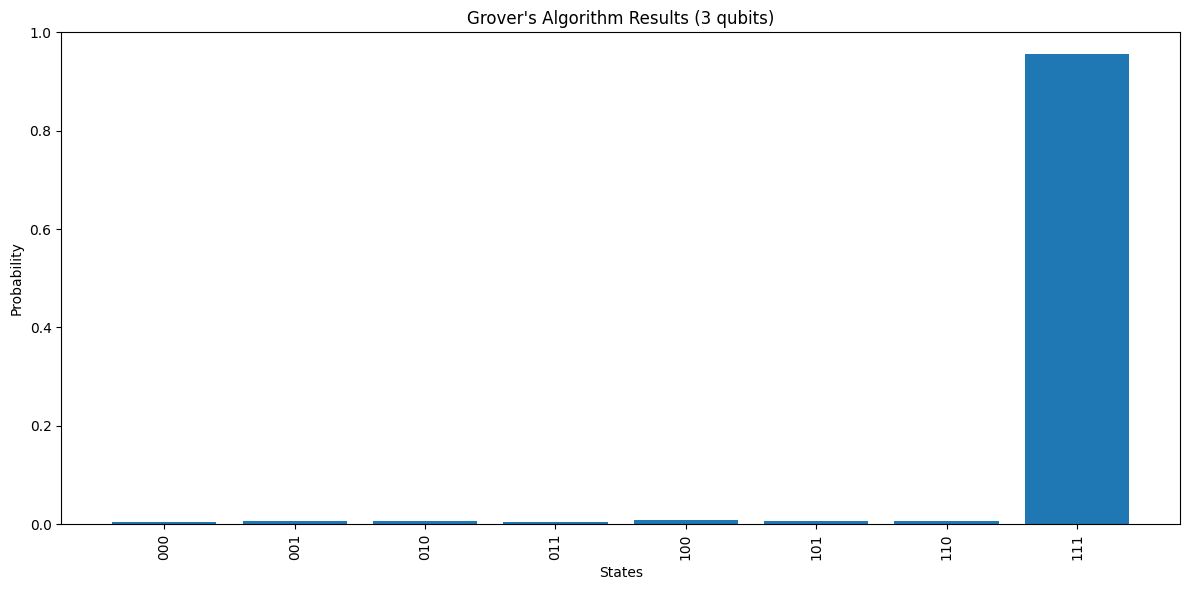

In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from collections import Counter
import math

def oracle_mark_state(circuit, qubits, marked_state):
    """
    Oracle that marks any given state.
    
    Args:
        circuit: QuantumCircuit to apply oracle to
        qubits: List of quantum registers to use
        marked_state: String representing the state to mark (e.g., "101", "0110")
    """
    n = len(qubits)
    
    # Flip qubits where the marked state has '0'
    for i, bit in enumerate(marked_state):
        if bit == '0':
            circuit.x(qubits[i])
    
    # Multi-controlled Z gate using H-CCX-H pattern on last qubit
    circuit.h(qubits[-1])
    
    # Multi-controlled X gate
    if n == 2:
        circuit.cx(qubits[0], qubits[1])
    elif n == 3:
        circuit.ccx(qubits[0], qubits[1], qubits[2])
    else:
        # For more qubits, use multi-controlled gate
        circuit.mcx(qubits[:-1], qubits[-1])
    
    circuit.h(qubits[-1])
    
    # Flip back the qubits
    for i, bit in enumerate(marked_state):
        if bit == '0':
            circuit.x(qubits[i])

def diffuser(circuit, qubits):
    """
    Grover diffuser (inversion about average).
    Works for any number of qubits.
    
    Args:
        circuit: QuantumCircuit to apply diffuser to
        qubits: List of quantum registers to use
    """
    n = len(qubits)
    
    # Apply Hadamard to all qubits
    for qubit in qubits:
        circuit.h(qubit)
    
    # Apply X to all qubits
    for qubit in qubits:
        circuit.x(qubit)
    
    # Multi-controlled Z gate using H-MCX-H pattern
    circuit.h(qubits[-1])
    
    if n == 2:
        circuit.cx(qubits[0], qubits[1])
    elif n == 3:
        circuit.ccx(qubits[0], qubits[1], qubits[2])
    else:
        circuit.mcx(qubits[:-1], qubits[-1])
    
    circuit.h(qubits[-1])
    
    # Apply X to all qubits
    for qubit in qubits:
        circuit.x(qubit)
    
    # Apply Hadamard to all qubits
    for qubit in qubits:
        circuit.h(qubit)

def grover_algorithm(n_qubits, oracle_function=None, marked_state=None, iterations=None):
    """
    Grover's search algorithm for n qubits.
    
    Args:
        n_qubits: Number of qubits to use (minimum 2)
        oracle_function: Function that applies the oracle (takes circuit and qubits as args)
        marked_state: String representing the state to mark (e.g., "101"). 
                      Used only if oracle_function is None
        iterations: Number of Grover iterations (if None, uses optimal number)
    
    Returns:
        circuit: The quantum circuit
    """
    if n_qubits < 2:
        raise ValueError("Minimum 2 qubits required")
    
    # Create oracle function from marked_state if oracle_function is not provided
    if oracle_function is None:
        if marked_state is None:
            raise ValueError("Either oracle_function or marked_state must be provided")
        oracle_function = lambda circuit, qubits: oracle_mark_state(circuit, qubits, marked_state)
    
    # Calculate optimal number of iterations if not provided
    if iterations is None:
        N = 2 ** n_qubits
        iterations = int(math.pi / 4 * math.sqrt(N))
    
    # Create quantum circuit
    qreg = QuantumRegister(n_qubits, 'q')
    creg = ClassicalRegister(n_qubits, 'c')
    circuit = QuantumCircuit(qreg, creg)
    
    # INITIALIZATION: Apply Hadamard to all qubits (superposition)
    for i in range(n_qubits):
        circuit.h(qreg[i])
    
    circuit.barrier(label='Init')
    
    # GROVER ITERATIONS
    for iteration in range(iterations):
        # Apply Oracle
        oracle_function(circuit, qreg)
        circuit.barrier(label=f'Oracle {iteration+1}')
        
        # Apply Diffuser
        diffuser(circuit, qreg)
        circuit.barrier(label=f'Diff {iteration+1}')
    
    # MEASUREMENT
    for i in range(n_qubits):
        circuit.measure(qreg[i], creg[i])
    
    return circuit

def run_grover(n_qubits, oracle_function=None, marked_state=None, shots=1000, iterations=None):
    """
    Run Grover's algorithm and display results.
    
    Args:
        n_qubits: Number of qubits
        oracle_function: Oracle function to use (takes circuit and qubits as args)
        marked_state: String representing the state to mark (e.g., "101"). 
                      Used only if oracle_function is None
        shots: Number of measurements
        iterations: Number of Grover iterations (optional)
    """
    # Create and run circuit
    circuit = grover_algorithm(n_qubits, oracle_function, marked_state, iterations)
    
    print(f"\nGrover's Algorithm with {n_qubits} qubits")
    print(f"Total states: {2**n_qubits}")
    print(f"Grover iterations: {iterations if iterations else int(math.pi / 4 * math.sqrt(2**n_qubits))}")
    if marked_state:
        print(f"Searching for state: |{marked_state}⟩")
    print("\nCircuit:")
    print(circuit.draw())
    
    # Simulate
    simulator = AerSimulator()
    result = simulator.run(circuit, shots=shots).result()
    counts = result.get_counts()
    
    print(f"\nMeasurement results ({shots} shots):")
    
    # Sort by count (descending)
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    for state, count in sorted_counts[:5]:  # Show top 5
        prob = count / shots
        print(f"|{state[::-1]}⟩: {count} ({prob:.3f})")
    
    # Create histogram
    all_states = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]
    full_counts = {state: 0 for state in all_states}
    
    for k, v in counts.items():
        reversed_k = k[::-1]
        if reversed_k in full_counts:
            full_counts[reversed_k] = v
    
    keys = list(full_counts.keys())
    values = list(full_counts.values())
    probs = [v / shots for v in values]
    
    plt.figure(figsize=(12, 6))
    plt.bar(keys, probs)
    plt.xticks(rotation=90)
    plt.title(f"Grover's Algorithm Results ({n_qubits} qubits)")
    plt.xlabel('States')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    return circuit, counts

# =============================================================================
# EXAMPLE: Run Grover's algorithm
# =============================================================================
# Simple usage - just specify the state to search:
# Alternative: use a custom oracle function if needed:
# circuit, counts = run_grover(3, oracle_function=my_custom_oracle)
circuit, counts = run_grover(3, marked_state="111")